# Summary

There are two main sections.

1: Basic data exploration

2: Data cleaning and processing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# Basic EDA

In [4]:
df = pd.read_csv('trump_tweets.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date').reset_index(drop=True)
df = df.rename(columns={"favorites":"likes"})
df['month'] = df.date.apply(lambda x: x.month)
df['year'] = df.date.apply(lambda x: x.year)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56571 entries, 0 to 56570
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        56571 non-null  int64         
 1   text      56571 non-null  object        
 2   device    56571 non-null  object        
 3   likes     56571 non-null  int64         
 4   retweets  56571 non-null  int64         
 5   date      56571 non-null  datetime64[ns]
 6   month     56571 non-null  int64         
 7   year      56571 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 3.5+ MB
None


In [5]:
df.head()

,id,text,device,likes,retweets,date,month,year
0,1698308935,Be sure to tune in and watch Donald Trump on L...,Twitter Web Client,939,519,2009-05-04 18:54:00,5,2009
1,1701461182,Donald Trump will be appearing on The View tom...,Twitter Web Client,259,34,2009-05-05 01:00:00,5,2009
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,Twitter Web Client,37,15,2009-05-08 13:38:00,5,2009
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,Twitter Web Client,29,11,2009-05-08 20:40:00,5,2009
4,1773561338,"""""""My persona will never be that of a wallflow...",Twitter Web Client,1877,1321,2009-05-12 14:07:00,5,2009


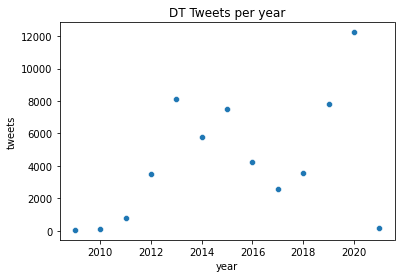

In [6]:
tweets_per_year = df.groupby('year').agg('count')['id']
_ = sns.scatterplot(data=tweets_per_year)
plt.ylabel('tweets')
plt.title('DT Tweets per year')
plt.show()

In [7]:
def at_mention(text):
    text = text.split()
    targets = []
    remove_chars = r'[:.\\!,\"?;()/=$#~`\'\[\]-]'
    for word in text:
        if '@' in word:
            w = re.sub(remove_chars, '', word).strip()
            if w[0] != '@':
                w = w[w.find('@'):]
            targets.append(w)
    if len(targets) == 0:
        targets = ['None']
    return targets

In [8]:
# Mentions
tweet_mentions = list(df.text.apply(lambda x: at_mention(x)))
tweet_mentions = list(filter(lambda x: (x != ['None']) and (x != ['@']), tweet_mentions))

mention_count = Counter()
for mentions in tweet_mentions:
    for mention in mentions:
        mention_count[mention]+=1
        
mention_list = [x[0] for x in mention_count.most_common(100)]

In [9]:
mention_df = pd.DataFrame(mention_list, columns=['mention'])
mention_df['total_count'] = mention_df.mention.apply(lambda x: df.text.apply(lambda y: x in y).sum())
mention_df['in_RT'] = mention_df.mention.apply(lambda x: df.text.apply(lambda y: (x in y) & ('RT' in y[:3])).sum())
mention_df['in_quote'] = mention_df.mention.apply(lambda x: df.text.apply(lambda y: (x in y) & ('"""' in y[:3])).sum())
mention_df['specific_mentions'] = mention_df.mention.apply(lambda x: \
    df.text.apply(lambda y: (x in y) & ('RT' not in y[:3]) & ('"""' not in y[:3])).sum())
mention_df

,mention,total_count,in_RT,in_quote,specific_mentions
0,@realDonaldTrump,10880,2623,8145,112
1,@FoxNews,963,98,212,653
2,@WhiteHouse,845,712,0,133
3,@foxandfriends,702,83,170,449
4,@BarackObama,726,7,29,690
...,...,...,...,...,...
95,@RepMattGaetz,52,52,0,0
96,@mcuban,51,0,18,33
97,@DRUDGE_REPORT,50,24,16,10
98,@BuckSexton,49,49,0,0


In [10]:
# Gut Check
(mention_df['total_count'] < (mention_df['in_RT'] + mention_df['in_quote'] + mention_df['specific_mentions'])).sum()

0

# Data Cleaning Tasks
## 1. HTML escape characters
    Escape characters for ampersands and other HTML characters are handled and cleaned
## 2. New line characters
    New line characters are removed
## 3. hyperlinks
    Hyperlinks are removed
## 4. Twitter Functionality
    a. Quotes are identified
    b. Retweets are identified
    c. @'s are included
    d. #'s are included

In [181]:
# Cleaning Functions

def split_ampersands(input_string):
    split = input_string.split('&')
    output = ''
    for item in split:
        output += item +'& '
    return output[:-2]

def white_space_remover(input_df):
    while input_df.text.apply(lambda x: '  ' in x).sum() > 0:
        input_df.text = input_df.text.apply(lambda x: x.replace('  ', ' '))

def hyperlink_remover(input_text):
    t = input_text.split()
    output_string = ""
    for word in t:
        if "http" in word:
            start=word.find("http")
            s = " " + word[:start]
            output_string += s
            output_string = output_string.strip()
        else:
            output_string += (" " + word)
            output_string = output_string.strip()
    return output_string

def is_retweet(input_string):
    return input_string[:2] == 'RT'

def blanker(input_string, condition = False):
    if condition:
        return ''
    else:
        return input_string

In [72]:
# Full Clean

def text_cleaner(input_df, drop_rt = False, drop_quote = False):
    output_df = input_df.copy()
    
    # Clean up HTML escape characters
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&amp;', '&')).apply(lambda x: x.replace('&amp','&'))
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&,', '&')).apply(lambda x: x.replace('&,', '&'))
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&…', '...')).apply(lambda x: x.replace('&...', '...'))
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&gt;', '>')).apply(lambda x: x.replace('&gt','>'))
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&lt;', '<')).apply(lambda x: x.replace('&lt','<'))
    
    # Fix ampersands
    output_df['text'] = output_df.text.apply(lambda x: split_ampersands(x)) 
    white_space_remover(output_df)
    
    # Fix verified @'s
    output_df['text'] = output_df.text.apply(lambda x: x.replace('.@','@'))
    
    # Fix annoying elipses
    output_df['text'] = output_df.text.apply(lambda x: x.replace('…', '...'))
    
    # Clean out new line characters
    while output_df.text.apply(lambda x: ' \n' in x).sum() >0 :
        output_df['text'] = output_df.text.apply(lambda x: x.replace(' \n', '. '))
        white_space_remover(output_df)
    
    while output_df.text.apply(lambda x: '\n' in x).sum() > 0:
        output_df['text'] = output_df.text.apply(lambda x: x.replace('\n', '. '))
        white_space_remover(output_df)
    
    # Remove hyperlinks
    output_df['text'] = output_df.text.apply(lambda x: hyperlink_remover(x))
    white_space_remover(output_df)
    
    if drop_rt:
        output_df['text'] = output_df.text.apply(lambda x: blanker(x, is_retweet(x)))
    
    if drop_quote:
        output_df['text'] = output_df.text.apply(lambda x: blanker(x, is_quote(x)))
    
    # Clear out tweets that have been blanked
    output_df['text'] = output_df.text.apply(lambda x: x if ((len(str(x))>0) & (str(x)!='nan'))else np.nan)
    output_df.dropna(inplace=True)
    
    return output_df


# Dealing with Quotes

In [197]:
def is_quote(input_string, debug=False):
    if debug: print(input_string)
    return (input_string[:3] == '"""')

def is_attribution(input_text):
    if input_text[:3] != '"""':
        return False
    if is_full_quote(input_text):
        return False
    attribution_flags = re.compile(r'"" -|""-|" -|"-|"" –|""–|" –|"–')
    result = attribution_flags.search(input_text)
    if result == None:
        return False
    else:
        return True

def is_quote_reply(input_text, debug=False):
    if input_text[:3] != '"""':
        if debug: print('Start not triple quote')
        return False
    if input_text[-1] != '"':
        if debug: print('End not quote')
        return False
    if input_text[-3:] == '"""':
        if debug: print('End not triple quote')
        return False
    if is_attribution(input_text):
        if debug: print('is attribution')
        return False
    flags = re.compile(r'[^"]""[^"]')
    result = flags.search(input_text)
    if result == None:
        if debug: print('double quote not found')
        return False
    else:
        return True
    
def is_full_quote(input_text):
    if input_text[:3] == '"""' and input_text[-3:] == '"""':
        return True
    else:
        return False 

def is_remainder(input_text):
    return not (is_attribution(input_text) | is_quote_reply(input_text) | is_full_quote(input_text))

In [168]:
# Tokenizer Functions

QS = '<QS>' # quote start
QE = '<QE>' # quote end
RS = '<RS>' # reply start
RE = '<RE>' # reply end
RT = '<RT>' # retweet
AT = '<AT>' # @ mentions

def quote_tokenizer(input_text):
    if is_quote(input_text):
        output_text = ''
        if is_full_quote(input_text):
            while input_text[-1] == '"':
                input_text = input_text[:-1]
            output_text = QS + '"' + input_text[3:] + '"' + QE
            return output_text
        if is_quote_reply(input_text):
            end_quote = input_text[3:].rindex('""')
            assert end_quote > 0, 'improper reply'
            output_text = QS + '"' + input_text[3:end_quote] + '"' + QE+RS+input_text[end_quote+2:-1]+RE
            return output_text
    return input_text

def rt_tokenizer(input_text):
    if is_retweet(input_text):
        return RT+input_text[2:]
    return input_text

def double_quote_cleaner(input_text):
    output_text = input_text
    while '""' in output_text:
        output_text = output_text.replace('""', '"')
    return output_text

def at_tokenizer(input_text):
    return input_text.replace('@', '<AT>@')

In [214]:
def tokenize(output_df):
    output_df = output_df.copy()
    
    # Remove quotes that aren't categorized (e.g. not full quotes, quote-replies)
    output_df['text'] = output_df[output_df.text.apply(lambda x: not (is_quote(x) & is_remainder(x)))]['text']
    output_df = output_df.dropna()
    output_df['text'] = output_df.text.apply(lambda x: quote_tokenizer(x))
    output_df['text'] = output_df.text.apply(lambda x: rt_tokenizer(x))
    output_df['text'] = output_df.text.apply(lambda x: double_quote_cleaner(x))
    output_df['text'] = output_df.text.apply(lambda x: at_tokenizer(x))
    
    return output_df

In [195]:
test = '"""This is quoted text" This is a reply to quoted text"'

is_quote_reply(test, debug=True)

double quote not found


False

In [166]:
df.text.apply(lambda x: double_quote_cleaner(x))

0        Be sure to tune in and watch Donald Trump on L...
1        Donald Trump will be appearing on The View tom...
2        Donald Trump reads Top Ten Financial Tips on L...
3        New Blog Post: Celebrity Apprentice Finale and...
4        "My persona will never be that of a wallflower...
                               ...                        
56566                              https://t.co/Pm2PKV0Fp3
56567    These are the things and events that happen wh...
56568                              https://t.co/csX07ZVWGe
56569    The 75,000,000 great American Patriots who vot...
56570    To all of those who have asked, I will not be ...
Name: text, Length: 56571, dtype: object

In [206]:
# Joining 'Threads' together

def possible_thread(input_string):
    return '..' in input_string[-2:]

def possible_continuation(input_string):
    return '..' in input_string[:2] and '..' in input_string[-2]

def possible_end(input_string):
    return '..' in input_string[:2]
                                                             

def period_remover(input_string, operation):
    s = input_string
    if operation == 'start': 
        while s[-1] == ('.' or '…'):
            s = s[:-1]
        s = s+" "
    if operation == 'middle':
        while s[0] == ('.' or '…'):
            s = s[1:]
        while s[-1] == ('.' or '…'):
            s = s[:-1]
        s = s+" "
    if operation == 'end':
        while s[0] == '.':
            s = s[1:]
    return s

# Didn't build it to handle the last element ending in '..'
def thread_joiner(input_df):
    joined_threads = []
    output_df = input_df.copy()
    
    output_df['start_thread'] = output_df.text.apply(lambda x: possible_thread(x)) # True/False
    output_df['cont_thread'] = output_df.text.apply(lambda x: possible_continuation(x)) # True/False
    output_df['end_thread'] = output_df.text.apply(lambda x: possible_end(x)) # True/False
    output_df['flag'] = False
    
    for i in range(len(output_df)):
        if output_df.iloc[i]['start_thread'] and \
        (output_df.iloc[i+1]['cont_thread'] or output_df.iloc[i+1]['end_thread']):
            text = period_remover(output_df.iloc[i]['text'], 'start')
            j = i+1
            while output_df.iloc[j]['cont_thread']:
                j+=1
                output_df.iloc[j,-1] = True
            for k in range(i+1, j):
                text += period_remover(output_df.iloc[k]['text'], 'middle')
                output_df.iloc[k,-1] = True
            output_df.iloc[j,-1] = True
            text += period_remover(output_df.iloc[j]['text'], 'end')
            
            
            output_df.iloc[i,0] = text
            joined_threads.append(text)
    output_df = output_df.drop(output_df[output_df['flag']==True].index)
    output_df = output_df.drop(['start_thread', 'cont_thread','end_thread', 'flag'], axis=1)
    output_df = output_df.dropna()
    output_df = output_df.reset_index(drop=True)
    return output_df, joined_threads         
    

In [207]:
clean_df = text_cleaner(df)

In [208]:
clean_df, joined_thread_record = thread_joiner(clean_df)

In [213]:
len(df) - len(clean_df)

2285

In [216]:
foo = tokenize(clean_df)

In [219]:
foo

,id,text,device,likes,retweets,date,month,year
0,1698308935,Be sure to tune in and watch Donald Trump on L...,Twitter Web Client,939,519,2009-05-04 18:54:00,5,2009
1,1701461182,Donald Trump will be appearing on The View tom...,Twitter Web Client,259,34,2009-05-05 01:00:00,5,2009
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,Twitter Web Client,37,15,2009-05-08 13:38:00,5,2009
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,Twitter Web Client,29,11,2009-05-08 20:40:00,5,2009
4,1773561338,"""My persona will never be that of a wallflower...",Twitter Web Client,1877,1321,2009-05-12 14:07:00,5,2009
...,...,...,...,...,...,...,...,...
54281,1346900000000000000,Please support our Capitol Police and Law Enfo...,Twitter for iPhone,582183,107460,2021-01-06 19:38:00,1,2021
54282,1346910000000000000,I am asking for everyone at the U.S. Capitol t...,Twitter for iPhone,730357,156100,2021-01-06 20:13:00,1,2021
54283,1346950000000000000,These are the things and events that happen wh...,Twitter for iPhone,0,0,2021-01-06 23:01:00,1,2021
54284,1347560000000000000,"The 75,000,000 great American Patriots who vot...",Twitter for iPhone,480997,108844,2021-01-08 14:46:00,1,2021


In [228]:
bar = np.random.choice(foo.text,5)
for item in bar:
    print(item)
    print()

Ebola patient Duncan lied on his exit papers by saying he never came into contact with a person with Ebola. He knew he did, and person died.

All-Star Celebrity <AT>@ApprenticeNBC continues to surprise our loyal viewers each and every week. More, and bigger, coming...

“Trump Fundraising Haul Shows Impeachment Backfiring on Dems”

<RT> <AT>@SenateGOP: We're ALL in this together.. . And we can ALL do our part to help stop the spread of coronavirus.. . ⬇️ Here's how ⬇️

States are safely coming back. Our Country is starting to OPEN FOR BUSINESS again. Special care is, and always will be, given to our beloved seniors (except me!). Their lives will be better than ever...WE LOVE YOU ALL!



In [135]:
clean_df.head()

,id,text,device,likes,retweets,date,month,year
0,1698308935,Be sure to tune in and watch Donald Trump on L...,Twitter Web Client,939,519,2009-05-04 18:54:00,5,2009
1,1701461182,Donald Trump will be appearing on The View tom...,Twitter Web Client,259,34,2009-05-05 01:00:00,5,2009
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,Twitter Web Client,37,15,2009-05-08 13:38:00,5,2009
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,Twitter Web Client,29,11,2009-05-08 20:40:00,5,2009
4,1773561338,"""""""My persona will never be that of a wallflow...",Twitter Web Client,1877,1321,2009-05-12 14:07:00,5,2009


In [ ]:
print(len(df), len(clean_df))

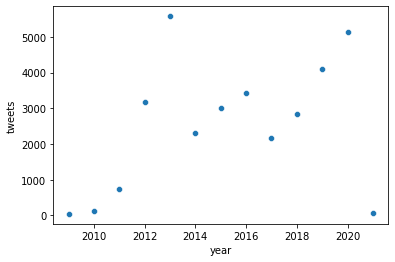

In [20]:
tweets_per_year = clean_df.groupby('year').agg('count')['id']
_ = sns.scatterplot(data=tweets_per_year)
plt.ylabel('tweets')
plt.show()

In [21]:
clean_df.to_csv('cleaned_tweets.csv', index=False)

In [22]:
full_df.to_csv('full_tweets.csv', index=False)

In [23]:
quotes = full_df[full_df.text.apply(lambda x: '"""' in x[:3])].text

In [24]:
len(quotes)

11558

In [25]:
# Quotes with responses
def is_quote_response(input_text):
    if '"""' not in input_text:
        return False
    if input_text[-2] != '"':
        return True
    else:
        return False

### Types of quote tweets:

Full Quotes: Either start AND end in """, end in singular ", or ends in nothing.

Quote-reply: Starts with """ and has "" right before the reply.

Manual Quote Attribution: Has a quote wrapped by "" and then a manual text attribution, often with preceding -'s


In [27]:
total_quotes = len(quotes)
attributions = quotes.apply(lambda x: is_attribution(x)).sum()
quote_reply = quotes.apply(lambda x: is_quote_reply(x)).sum()
full_quotes = quotes.apply(lambda x: is_full_quote(x)).sum()
print(f'Total: {total_quotes}')
print(f'Attributions: {attributions}')
print(f'Quote Replies: {quote_reply}')
print(f'Full Quotes: {full_quotes}')
print(f'Unaccounted For: {total_quotes - attributions - quote_reply - full_quotes}')

Total: 11558
Attributions: 360
Quote Replies: 3691
Full Quotes: 4886
Unaccounted For: 2621


In [28]:
remainders = quotes.apply(lambda x: not (is_attribution(x) | is_quote_reply(x) | is_full_quote(x)) )

### There appears to be no indication that 'cont' is used as a threading mechanism. Even after referencing back with the original df.

In [ ]:
# Special Tokens
QS = '<QS>'
QE = '<QE>'
reply = '<r>'